In [1]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import seaborn as sns
import pandas as pd


# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

model_dir = './models/'
model_file = model_dir + 'unetpp.keras'

Keras = 2.15.0
Num GPUs Available:  1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
! unzip -o drive/MyDrive/dataset_19.zip

! pwd

Archive:  drive/MyDrive/dataset_19.zip
  inflating: dataset_19/glioma/Te-gl_0010.jpg  
  inflating: dataset_19/glioma/Te-gl_0016.jpg  
  inflating: dataset_19/glioma/Te-gl_0020.jpg  
  inflating: dataset_19/glioma/Te-gl_0026.jpg  
  inflating: dataset_19/glioma/Te-gl_0035.jpg  
  inflating: dataset_19/glioma/Te-gl_0041.jpg  
  inflating: dataset_19/glioma/Te-gl_0043.jpg  
  inflating: dataset_19/glioma/Te-gl_0044.jpg  
  inflating: dataset_19/glioma/Te-gl_0045.jpg  
  inflating: dataset_19/glioma/Te-gl_0057.jpg  
  inflating: dataset_19/glioma/Te-gl_0060.jpg  
  inflating: dataset_19/glioma/Te-gl_0075.jpg  
  inflating: dataset_19/glioma/Te-gl_0079.jpg  
  inflating: dataset_19/glioma/Te-gl_0085.jpg  
  inflating: dataset_19/glioma/Te-gl_0090.jpg  
  inflating: dataset_19/glioma/Te-gl_0107.jpg  
  inflating: dataset_19/glioma/Te-gl_0114.jpg  
  inflating: dataset_19/glioma/Te-gl_0125.jpg  
  inflating: dataset_19/glioma/Te-gl_0126.jpg  
  inflating: dataset_19/glioma/Te-gl_0127.jpg  
 

# Load the data

In [4]:
# Data Directories
dir = "dataset_19/"


## Data Distribution

In [5]:
data_distribution_count = pd.Series(
    {curr_index: len(os.listdir(os.path.join(dir, curr_index))) for curr_index in os.listdir(dir)})

data_distribution_count

meningioma    120
pituitary     120
glioma        120
notumor       120
dtype: int64

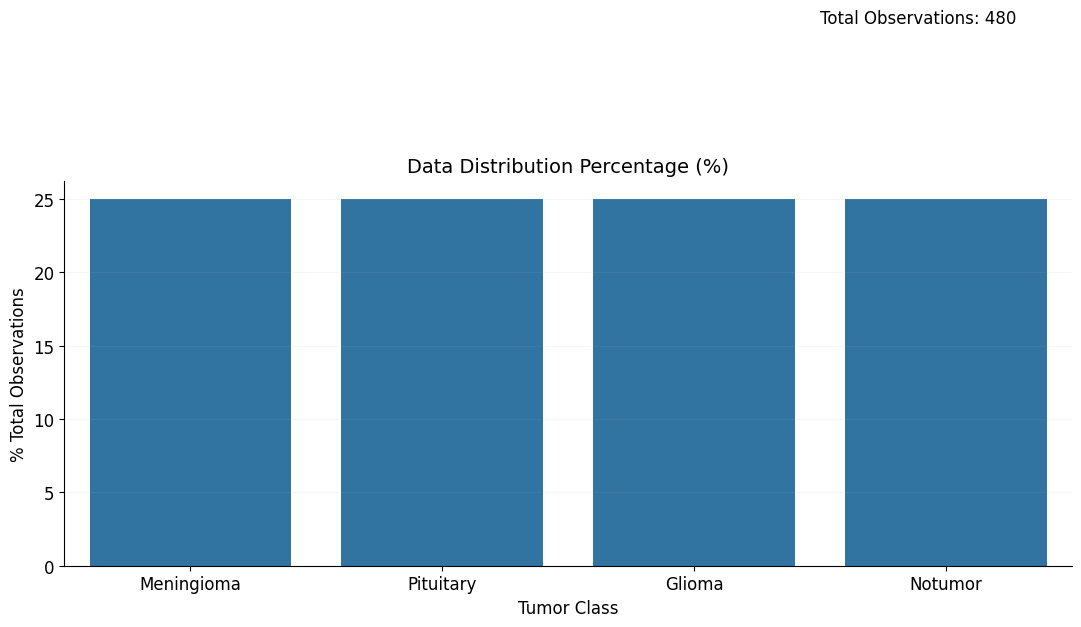

In [6]:
fig, axis = plt.subplots(figsize=(13, 5))
axis.grid(True, alpha=0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize=14)
sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y=100 * data_distribution_count / data_distribution_count.sum(), ax=axis)
axis.set_xlabel("Tumor Class", fontsize=12)
axis.set_ylabel("% Total Observations", fontsize=12)
axis.tick_params(which='major', labelsize=12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
sns.despine()

# Preprocess Data


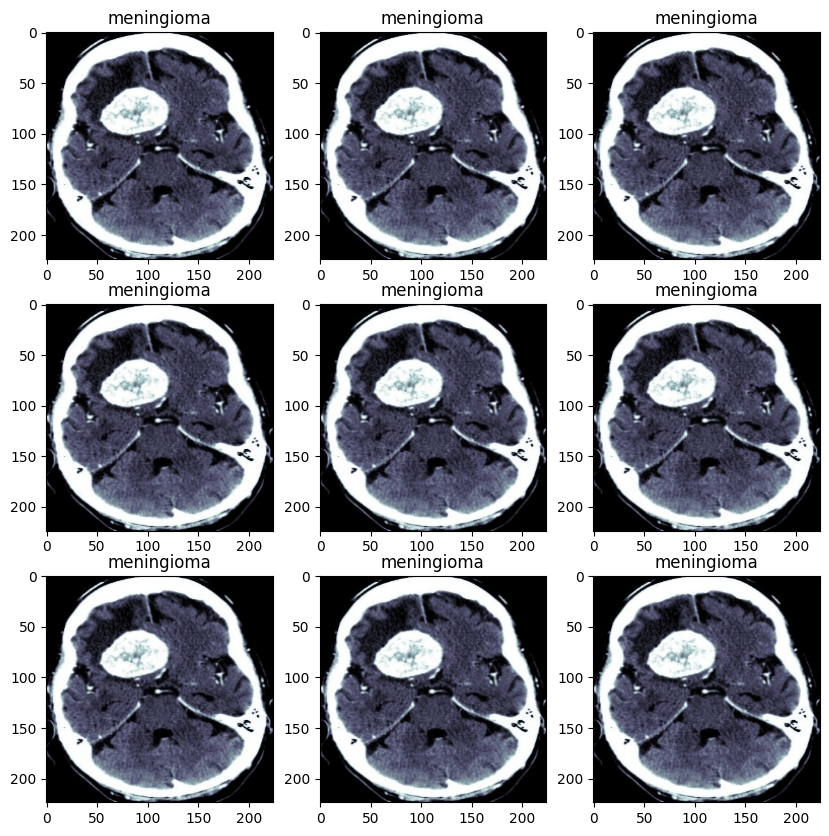

In [22]:
from tqdm import tqdm
import cv2
import imutils

def crop_img(img):

  # Find extreme points on the image and crop the rectangular out

  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  gray = cv2.GaussianBlur(gray, (3, 3), 0)

  # threshold the image, then perform a series of erosions +
  # dilations to remove any small regions of noise
  thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)

  # find contours in thresholded image, then grab the largest one
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)

  # find the extreme points
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])
  ADD_PIXELS = 0
  new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

  return new_img

def preprocess_images(directory):
    for dir in os.listdir(directory):
        path = os.path.join(directory, dir)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            cropped_img = crop_img(img)
            processed_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2GRAY)
            processed_img = cv2.bilateralFilter(processed_img, 2, 50, 50)
            processed_img = cv2.applyColorMap(processed_img, cv2.COLORMAP_BONE)
            processed_img = cv2.resize(processed_img, (224, 224))
            cv2.imwrite(img_path, processed_img)


# Preprocess the images before generating data
preprocess_images(dir)

# Display 9 image using matplotlib
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    for curr_index in os.listdir(dir):
        path = os.path.join(dir, curr_index)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            image = plt.imread(img_path)
            plt.imshow(image)
            plt.title(curr_index)
            break
        break


## Splitting the data

In [65]:
classes = os.listdir(dir)

batch_size = 10

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20,
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255,
                                        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    subset='training'
)

test_generator = validation_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    shuffle = False,
    subset='validation')


print(test_generator.class_indices)


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# Model Training

In [15]:
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.0 MB/s eta 0:00:00


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_12 (Functional)       (None, 224, 224, 4)       10115936  
                                                                 
 global_average_pooling2d_5  (None, 4)                 0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 4)                 20        
                                                                 
Total params: 10115956 (38.59 MB)
Trainable params: 10071956 (38.42 MB)
Non-trainable params: 44000 (171.88 KB)
_________________________________________________________________


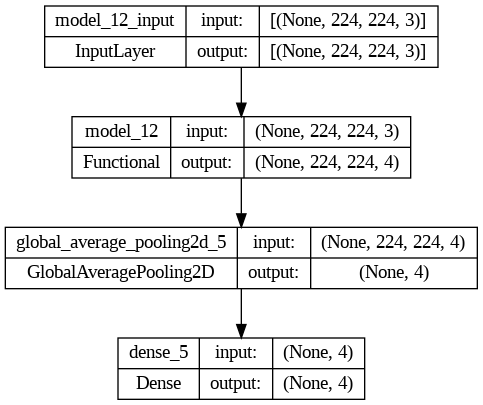

In [78]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
from segmentation_models import Unet

# Model parameters
input_shape = (224, 224, 3)
num_classes = 4
initial_learning_rate = 1e-4

# Define the U-Net++ model
model = Unet('efficientnetb0', input_shape=input_shape, classes=num_classes, activation=None)
tf.keras.utils.plot_model(model, to_file='unetpp_model.png', show_shapes=True, show_layer_names=True)

# Add a GlobalAveragePooling2D layer to collapse spatial dimensions
model = keras.Sequential([
    model,
    keras.layers.GlobalAveragePooling2D()  # Pool across spatial dimensions
])

# Add a Dense layer with softmax activation for final classification
model.add(keras.layers.Dense(num_classes, activation='softmax'))

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()
tf.keras.utils.plot_model(model, to_file='unetpp_model2.png', show_shapes=True, show_layer_names=True)


In [66]:
from keras.callbacks import *

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.3, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)


Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 0.1709 - accuracy: 0.9412
Epoch 1: val_loss improved from inf to 0.08028, saving model to ./models/inception.keras
38/38 [==============================] - 10s 265ms/step - loss: 0.1709 - accuracy: 0.9412 - val_loss: 0.0803 - val_accuracy: 0.9778 - lr: 3.0000e-05
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 0.1348 - accuracy: 0.9545
Epoch 2: val_loss improved from 0.08028 to 0.06184, saving model to ./models/inception.keras
38/38 [==============================] - 10s 257ms/step - loss: 0.1348 - accuracy: 0.9545 - val_loss: 0.0618 - val_accuracy: 0.9778 - lr: 3.0000e-05
Epoch 3/100
38/38 [==============================] - ETA: 0s - loss: 0.1009 - accuracy: 0.9759
Epoch 3: val_loss improved from 0.06184 to 0.05597, saving model to ./models/inception.keras
38/38 [==============================] - 11s 276ms/step - loss: 0.1009 - accuracy: 0.9759 - val_loss: 0.0560 - val_accuracy: 0.9778 - lr: 3.00

# Testing the Model

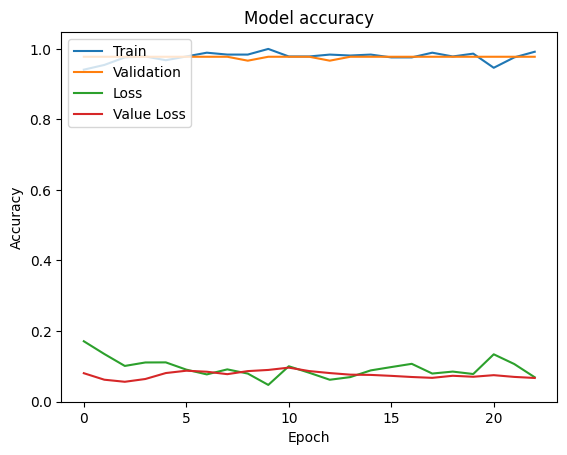

In [67]:
# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','Loss', 'Value Loss'], loc='upper left')
plt.show()

In [68]:
# Validate the model with test data

model = keras.models.load_model(model_file)
model.evaluate(test_generator)


# Predict and Display image using matplotlib
# plt.figure(figsize=(20, 20))
# for i in range(9):
#     plt.subplot(3, 3, i + 1)
#     for X_batch, Y_batch in test_generator:
#         image = X_batch[0]
#         # Print Class
#         plt.title("Predicted: " + classes[predictions[i]] + "\nActual: " + classes[np.argmax(Y_batch[i])])

#         plt.imshow(image)
#         break


10/10 [==============================] - 3s 55ms/step - loss: 0.0532 - accuracy: 0.9792


[0.053204234689474106, 0.9791666865348816]

# Model Visualisation (Evaluation)

10/10 [==============================] - 1s 59ms/step


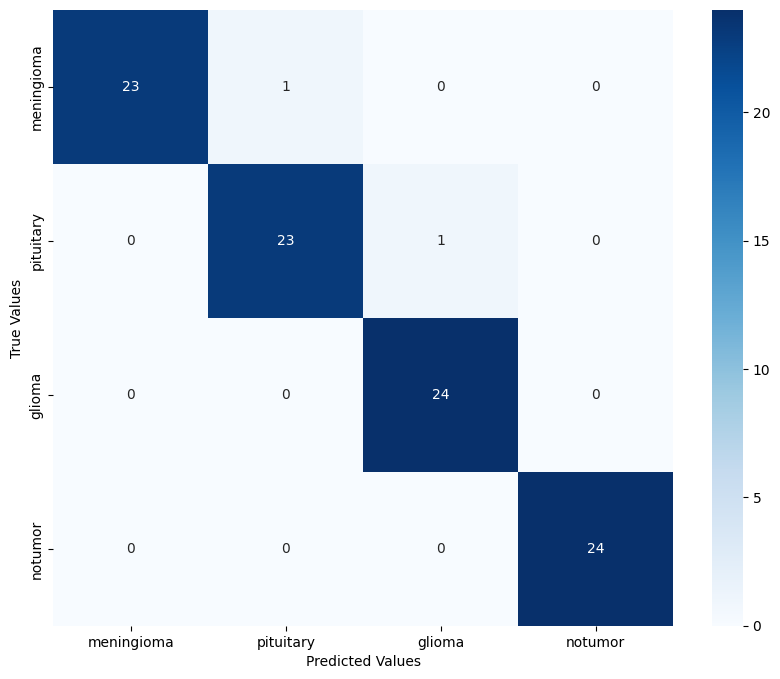

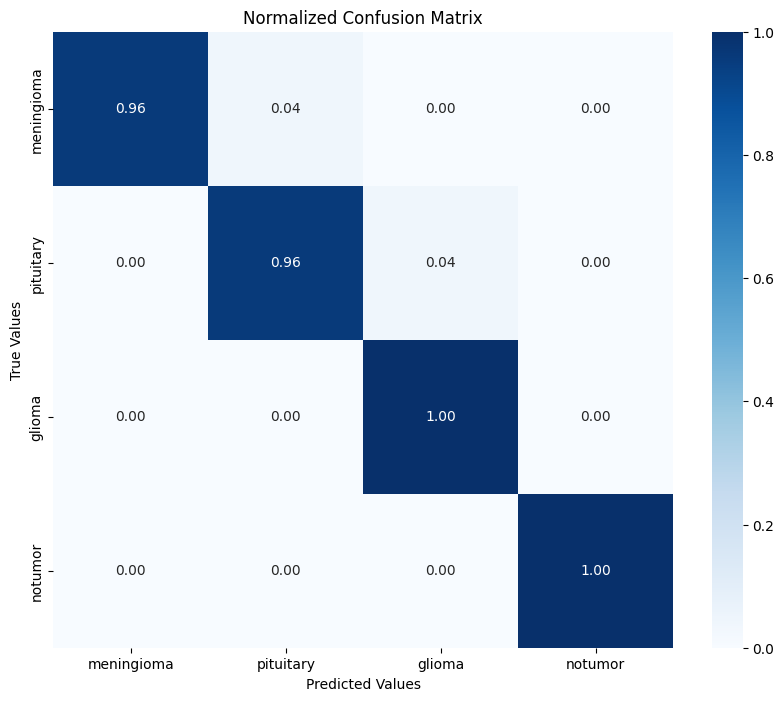

DSC: 0.9791621435808366, Sensitivity: 0.9791666666666667, Specificity: 0.9930555555555556, Accuracy: 0.9791666666666666


In [71]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

classes = ['meningioma', 'pituitary', 'glioma', 'notumor']

def calculate_metrics(y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.show()

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Calculate metrics for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return dsc, sensitivity, specificity, accuracy

# Predict the output
predictions_prob = model.predict(test_generator)
predictions = np.argmax(predictions_prob, axis=1)

dsc, sensitivity, specificity, accuracy = calculate_metrics(test_generator.classes, predictions)
print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")


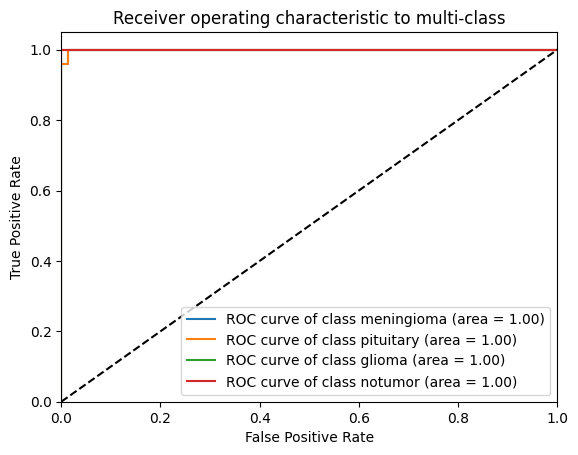

              precision    recall  f1-score   support

  meningioma       1.00      0.96      0.98        24
   pituitary       0.96      0.96      0.96        24
      glioma       0.96      1.00      0.98        24
     notumor       1.00      1.00      1.00        24

   micro avg       0.98      0.98      0.98        96
   macro avg       0.98      0.98      0.98        96
weighted avg       0.98      0.98      0.98        96
 samples avg       0.98      0.98      0.98        96



In [72]:
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np

# Binarize the output
lb = LabelBinarizer()
y_test = lb.fit_transform(test_generator.classes)
y_pred = lb.transform(predictions)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i, class_name in enumerate(classes):
    plt.plot(fpr[i], tpr[i],
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_name, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=classes))